# Matlab testbench model state-space matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
import opentorsion as ot
import cvxpy as cp

In [2]:
#plt.style.use(['science', 'ieee'])
#plt.rcParams["figure.figsize"] = (6,4)

In [3]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [4]:
time_steps = np.genfromtxt('../../data/ice_excitation/times.csv', delimiter=',')
motor = np.genfromtxt('../../data/ice_excitation/motor.csv', delimiter=',')
propeller = np.genfromtxt('../../data/ice_excitation/propeller.csv', delimiter=',')
angular_speeds = np.genfromtxt('../../data/ice_excitation/speed_measurements.csv', delimiter=',')
shaft_torque = np.genfromtxt('../../data/ice_excitation/torque_measurements.csv', delimiter=',')

In [5]:
A_mat = np.genfromtxt('../../data/testbench_A.csv', delimiter=',')
B_mat = np.genfromtxt('../../data/testbench_B.csv', delimiter=',')
C_mat = np.genfromtxt('../../data/testbench_C.csv', delimiter=',')
D_mat = np.genfromtxt('../../data/testbench_D.csv', delimiter=',')

ts = np.mean(np.diff(time_steps))
A_mat_d, B_mat_d = c2d(A_mat, B_mat, ts)
UU = np.vstack((motor, propeller)).T

In [6]:
# calculate an initial state for the discrete-time simulation
CCc = np.eye(B_mat.shape[0])
DDc = np.zeros((CCc.shape[0], B_mat.shape[1]))
_, initial_states_c, _ = lsim((A_mat, B_mat, CCc, DDc), UU, time_steps)

In [7]:
# continuous-time simulation
tout_mat, yout_mat, xout_mat = lsim((A_mat, B_mat, C_mat, D_mat), UU, time_steps, X0=initial_states_c[-1,:])

In [8]:
# calculate an initial state for the discrete-time simulation
CC = np.eye(B_mat_d.shape[0])
DD = np.zeros((CC.shape[0], B_mat_d.shape[1]))
_, initial_states, _ = dlsim((A_mat_d, B_mat_d, CC, DD, ts), UU, t=time_steps)

In [9]:
dtout_mat, dyout_mat, dxout_mat = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, ts), UU, t=time_steps, x0=initial_states[-1,:])

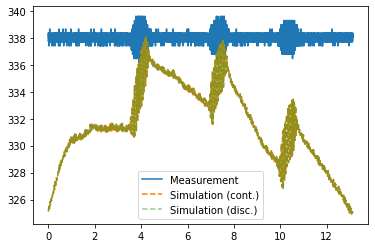

In [10]:
plt.plot(time_steps, angular_speeds[0,:], label='Measurement')
plt.plot(tout_mat, yout_mat[:,0], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,0], '--', label='Simulation (disc.)', alpha=0.5)
plt.legend()
plt.show()

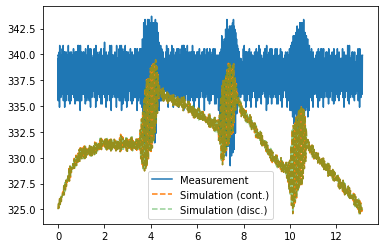

In [11]:
plt.plot(time_steps, angular_speeds[1,:], label='Measurement')
plt.plot(tout_mat, yout_mat[:,1], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,1], '--', label='Simulation (disc.)', alpha=0.5)
plt.legend()
#plt.xlim(6,12)
#plt.ylim(325,345)
plt.show()

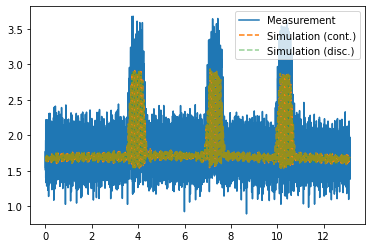

In [12]:
plt.plot(time_steps, shaft_torque, label='Measurement')
plt.plot(tout_mat, yout_mat[:,2], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,2], '--', label='Simulation (disc.)', alpha=0.5)
plt.legend()
plt.show()

# Input and state estimation functions

In [13]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [14]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [15]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [16]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)
    
    # delete incomplete rows
    D2 = D2[:-2*m, :]
    
    return D2

In [18]:
def tikhonov_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a Tikhonov regularization problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    prob = cp.Problem(objective)
    prob.solve(warm_start=False)

    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

In [19]:
def lasso_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve(warm_start=False)
    
    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

# Tikhonov regularization and $\ell_1$- regularization

## Impulse load

In [20]:
t = np.arange(0, 1.200, 0.002)
d_t = np.mean(np.diff(t))
N = len(t)
m = B_mat_d.shape[1]

# Impulse load applied at first and last nodes
impulse_ex = np.zeros((len(t), 2))
ramp = np.arange(0, 0.5, 1/16)
ramp2 = np.arange(0, 1, 1/8)

impulse_ex[22:30,0] = ramp
impulse_ex[30,0] = 0.5
impulse_ex[31:39,0] = ramp[::-1]

impulse_ex[42:50,1] = ramp2
impulse_ex[50,1] = 1
impulse_ex[51:59,1] = ramp2[::-1]

In [21]:
O_test = O(A_mat_d, C_mat, N)
G_test = gamma(A_mat_d, B_mat_d, C_mat, N)
x0d = np.zeros(O_test.shape[1])
x0 = np.zeros((O_test.shape[1],1))

In [22]:
dtout_imp, dyout_imp, dxout_imp = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, d_t), impulse_ex, t=t, x0=x0d)

impulse_ex_reshaped = impulse_ex.reshape(-1, 1)

y_hat = O_test @ x0 + G_test @ impulse_ex_reshaped

meases = np.hstack(np.vsplit(y_hat, N))

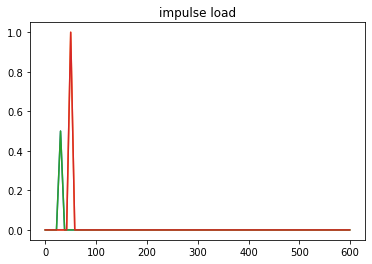

In [23]:
plt.plot(impulse_ex)
plt.plot(impulse_ex_reshaped[::2])
plt.plot(impulse_ex_reshaped[1::2])
plt.title('impulse load')
plt.show()

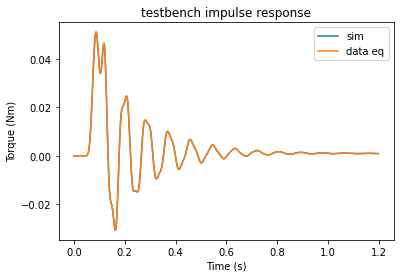

In [24]:
plt.plot(t, dyout_imp[:,-1], label='sim')
plt.plot(t, meases[-1,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench impulse response')
plt.show()

In [25]:
L_test = L(m*N)

R_ = 1e-3*np.eye(C_mat.shape[0]) # measurement covariance, shape (n_sensors, n_sensors)
r = np.random.multivariate_normal(np.zeros(R_.shape[0]), R_, t.shape[0])
e = np.reshape(r.T, (-1,1))

Y = np.reshape(dyout_imp, (-1,1))
noisy_meas = Y + e

In [26]:
u_hat, x_hat = tikhonov_problem(noisy_meas, O_test, G_test, L_test, initial_state=x0, lam=0.01)
u_hat_l, x_hat_l = lasso_problem(noisy_meas, O_test, G_test, L_test, initial_state=x0, lam=0.05)

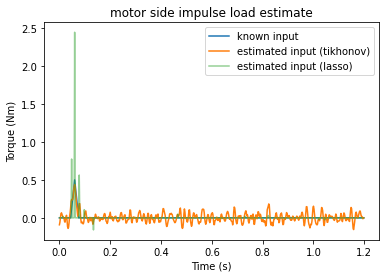

In [27]:
plt.plot(t, impulse_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side impulse load estimate')
plt.show()

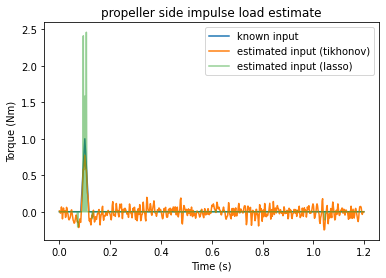

In [28]:
plt.plot(t, impulse_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side impulse load estimate')
plt.show()

# Step load

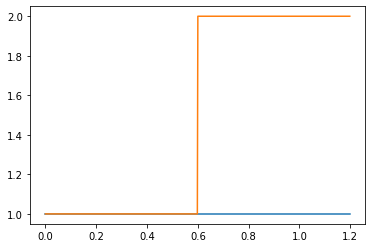

In [29]:
step_ex = np.ones((len(t), 2))
step_ex[300:,1] += 1

plt.plot(t, step_ex)
plt.show()

In [30]:
dtout_step, dyout_step, dxout_step = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, d_t), step_ex, t=t, x0=x0d)

step_ex_reshaped = step_ex.reshape(-1, 1)
y_hat_step = O_test @ x0 + G_test @ step_ex_reshaped
meases_step = np.hstack(np.vsplit(y_hat_step, N))

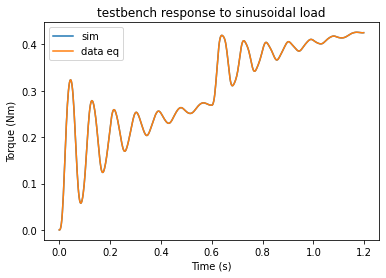

In [31]:
plt.plot(t, dyout_step[:,-1], label='sim')
plt.plot(t, meases_step[-1,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench response to sinusoidal load')
plt.show()

In [32]:
Y_step = np.reshape(dyout_step, (-1,1))
noisy_meas_step = Y_step + e

In [33]:
u_hat_step, x_hat_step = tikhonov_problem(noisy_meas_step, O_test, G_test, L_test, initial_state=x0, lam=0.01)
u_hat_l_step, x_hat_l_step = lasso_problem(noisy_meas_step, O_test, G_test, L_test, initial_state=x0, lam=0.05)

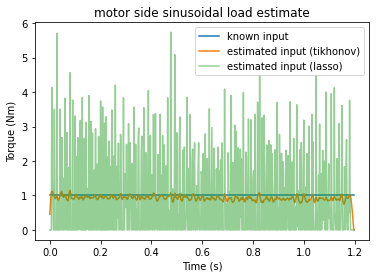

In [34]:
plt.plot(t, step_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_step[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_step[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate')
plt.show()

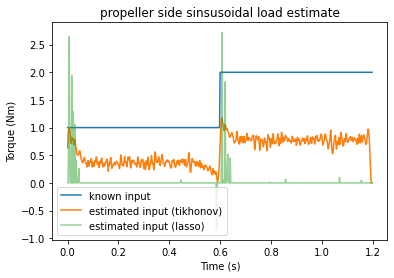

In [35]:
plt.plot(t, step_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_step[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_step[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinsusoidal load estimate')
plt.show()

## Sinusoidal load

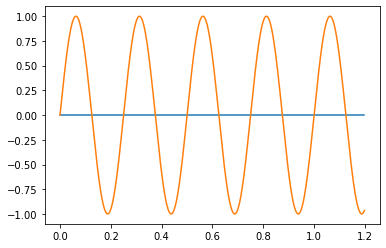

In [36]:
sin_ex = np.zeros((len(t), 2))
sin_ex[:,1] += np.sin(4*2*np.pi*t)

plt.plot(t, sin_ex)
plt.show()

In [37]:
dtout_sin, dyout_sin, dxout_sin = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, d_t), sin_ex, t=t, x0=x0d)

sin_ex_reshaped = sin_ex.reshape(-1, 1)
y_hat_sin = O_test @ x0 + G_test @ sin_ex_reshaped
meases_sin = np.hstack(np.vsplit(y_hat_sin, N))

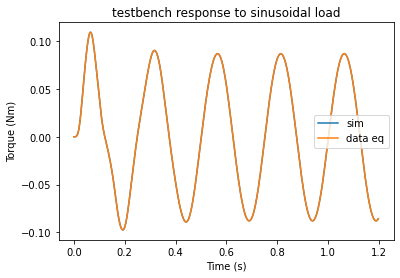

In [38]:
plt.plot(t, dyout_sin[:,-1], label='sim')
plt.plot(t, meases_sin[-1,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench response to sinusoidal load')
plt.show()

In [39]:
Y_sin = np.reshape(dyout_sin, (-1,1))
noisy_meas_sin = Y_sin + e

In [40]:
u_hat_sin, x_hat_sin = tikhonov_problem(noisy_meas_sin, O_test, G_test, L_test, initial_state=x0, lam=0.01)
u_hat_l_sin, x_hat_l_sin = lasso_problem(noisy_meas_sin, O_test, G_test, L_test, initial_state=x0, lam=0.05)

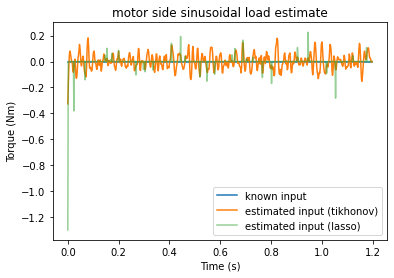

In [41]:
plt.plot(t, sin_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_sin[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_sin[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate')
plt.show()

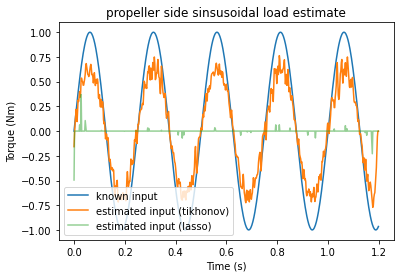

In [42]:
plt.plot(t, sin_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_sin[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_sin[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinsusoidal load estimate')
plt.show()

# Hodrick-Prescott trend filtering

## Impulse load

In [43]:
D2_test = second_difference_matrix(N, m)

u_hat_hp, x_hat_hp = tikhonov_problem(noisy_meas, O_test, G_test, D2_test, initial_state=x0, lam=0.01)
u_hat_l_hp, x_hat_l_hp = lasso_problem(noisy_meas, O_test, G_test, D2_test, initial_state=x0, lam=0.05)

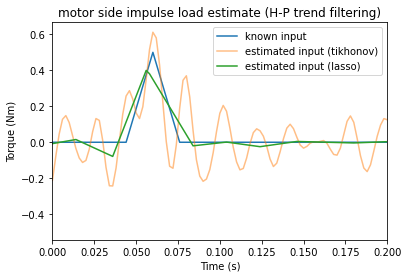

In [44]:
plt.plot(t, impulse_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_hp[::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp[::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim(0,0.2)
plt.title('motor side impulse load estimate (H-P trend filtering)')
plt.show()

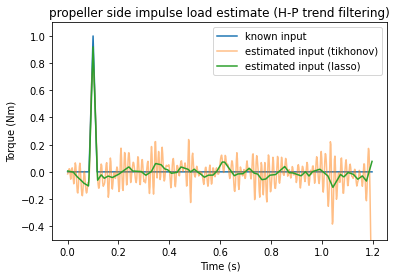

In [45]:
plt.plot(t, impulse_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_hp[1::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp[1::2], label='estimated input (lasso)')
plt.ylim(-0.5, 1.1)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side impulse load estimate (H-P trend filtering)')
plt.show()

In [46]:
u_hat_hp_step, x_hat_hp_step = tikhonov_problem(noisy_meas_step, O_test, G_test, D2_test, initial_state=x0, lam=0.01)
u_hat_hp_l_step, x_hat_hp_l_step = lasso_problem(noisy_meas_step, O_test, G_test, D2_test, initial_state=x0, lam=0.05)

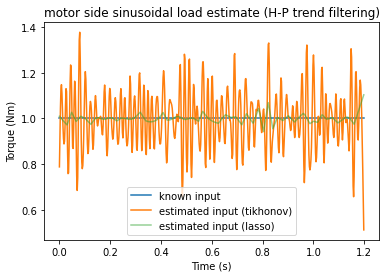

In [47]:
plt.plot(t, step_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_hp_step[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_hp_l_step[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate (H-P trend filtering)')
plt.show()

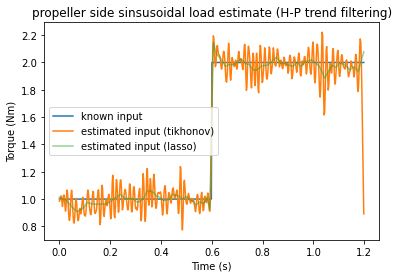

In [48]:
plt.plot(t, step_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_hp_step[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_hp_l_step[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinsusoidal load estimate (H-P trend filtering)')
plt.show()

In [49]:
u_hat_hp_sin, x_hat_hp_sin = tikhonov_problem(noisy_meas_sin, O_test, G_test, D2_test, initial_state=x0, lam=0.01)
u_hat_l_hp_sin, x_hat_l_hp_sin = lasso_problem(noisy_meas_sin, O_test, G_test, D2_test, initial_state=x0, lam=0.05)

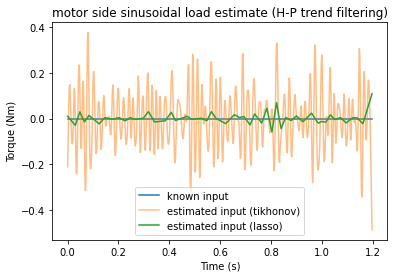

In [50]:
plt.plot(t, sin_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_hp_sin[::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp_sin[::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate (H-P trend filtering)')
plt.show()

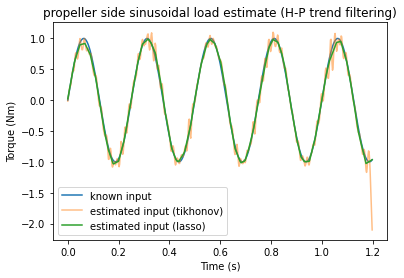

In [51]:
plt.plot(t, sin_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_hp_sin[1::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp_sin[1::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinusoidal load estimate (H-P trend filtering)')
plt.show()

In [52]:
out_est = O_test @ x0 + G_test @ u_hat_l_hp_sin

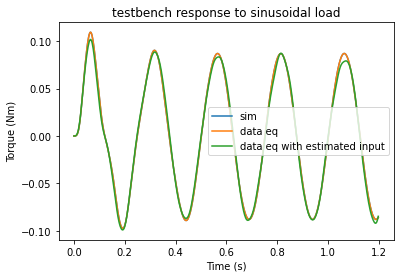

In [53]:
plt.plot(t, dyout_sin[:,-1], label='sim')
plt.plot(t, meases_sin[-1,:], label='data eq')
plt.plot(t, out_est[2::3], label='data eq with estimated input')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench response to sinusoidal load')
plt.show()

# Simulated experiments

## 1)

In [75]:
sim_time = np.arange(0, 10, 0.001)
dst = np.mean(np.diff(sim_time))
en = len(sim_time)
em = B_mat_d.shape[1]

U_step = np.zeros((len(sim_time), 2))

e1 = np.random.normal(0, .01, U_step.shape[0])
e2 = np.random.normal(0, .01, U_step.shape[0])

U_step[:,0] += 2.5 + e1
U_step[:,1] += e2
U_step[3800:,1] += 1.5

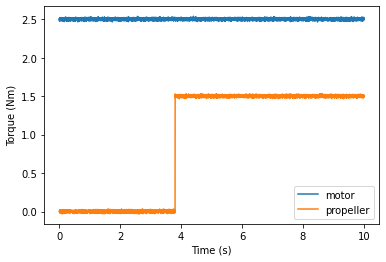

In [76]:
plt.plot(sim_time, U_step, label=('motor', 'propeller'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [77]:
time_meas_step, measurements_step, _ = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, dst), U_step, t=sim_time)

In [78]:
measurement_error = np.random.normal(0, .02, measurements_step.shape[0]).reshape(-1,1)
measurements_noise_step = measurements_step + measurement_error

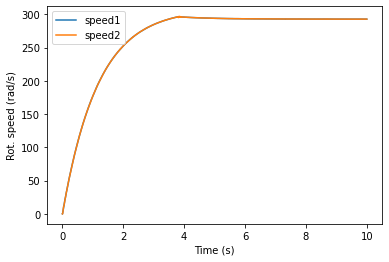

In [79]:
plt.plot(time_meas_step, measurements_noise_step[:,:-1], label=('speed1', 'speed2'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rot. speed (rad/s)')
plt.show()

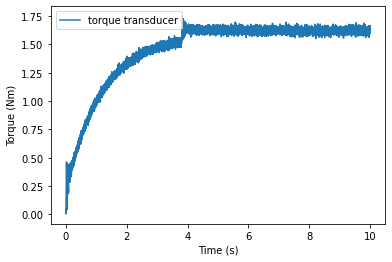

In [80]:
plt.plot(time_meas_step, measurements_noise_step[:,-1], label='torque transducer')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [81]:
# for initial state estimation
C_full = np.eye(B_mat_d.shape[0])
omat = O(A_mat_d, C_full, bs)
gmat = gamma(A_mat_d, B_mat_d, C_full, bs)

In [82]:
bs = 500 # batch size
loop_len = int(en/bs)
#B_mat_d1 = np.delete(B_mat_d, 0, 1)

D2_mat = second_difference_matrix(bs, B_mat_d.shape[1])
L_mat = L(bs*em)
O_mat = O(A_mat_d, C_mat, bs)
G_mat = gamma(A_mat_d, B_mat_d, C_mat, bs)
x_lasso = np.zeros((O_mat.shape[1], 1))

In [85]:
lasso_estimates = []

for i in range(loop_len):
    batch = measurements_noise_step[i*bs:(i+1)*bs,:]
    y_noise = batch.reshape(-1,1)
    
    print('Initial state estimate (LASSO):\n', x_lasso.T)
    
    lasso_estimate, x_lasso = lasso_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=x_lasso, lam=0.05)
    
    U_step_est = np.vstack((U_step[i*bs:(i+1)*bs,0], lasso_estimate[1::2].T)).T.reshape(-1,1)
    
    x_est_l = omat @ x_lasso + gmat @ U_step_est
    x_lasso = x_est_l[-A_mat_d.shape[0]:,:]
    
    print('New initial state estimate (LASSO):\n', x_lasso.T)
    
    lasso_estimates.append(lasso_estimate)

Initial state estimate (LASSO):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
New initial state estimate (LASSO):
 [[1.07274986e+02 1.07274988e+02 1.07275041e+02 1.07283820e+02
  1.07292604e+02 1.07288946e+02 1.07285283e+02 1.07274925e+02
  1.07274917e+02 1.07274849e+02 1.07274839e+02 1.07274805e+02
  3.57582552e+01 3.57582359e+01 3.57577082e+01 3.57576877e+01
  3.57576355e+01 8.93936168e+00 8.93934645e+00 8.93924133e+00
  8.93922602e+00 8.93905277e+00 1.06827815e-05 2.92605608e-04
  2.26086822e-02 2.26048305e-02 7.62910889e-03 7.62526774e-03
  2.27841537e-02 1.61809718e-05 1.25345878e-04 1.59230608e-05
  5.46617232e-05 1.92765417e-05 2.67036502e-05 7.23746985e-04
  2.64399132e-05 6.72066164e-05 6.25879220e-05 2.00729944e-05
  1.38489375e-04 2.00502269e-05 2.26938625e-04]]
Initial state estimate (LASSO):
 [[1.07274986e+02 1.07274988e+02 1.07275041e+02 1.07283820e+02
  1.07292604e+02 1.07288946e+02

New initial state estimate (LASSO):
 [[2.92777229e+02 2.92777212e+02 2.92776741e+02 2.92761792e+02
  2.92746893e+02 2.92749159e+02 2.92751427e+02 2.92753530e+02
  2.92753532e+02 2.92753545e+02 2.92753547e+02 2.92753554e+02
  9.75845298e+01 9.75845465e+01 9.75850013e+01 9.75850181e+01
  9.75850608e+01 2.43963134e+01 2.43963288e+01 2.43964355e+01
  2.43964509e+01 2.43966255e+01 8.49180157e-06 2.32653305e-04
  1.79235176e-02 1.79231564e-02 1.67441496e-02 1.67438546e-02
  4.99881498e-02 3.59388813e-05 2.78846428e-04 3.59230702e-05
  1.23450863e-04 4.11675537e-05 5.74882109e-05 1.55930347e-03
  5.74717902e-05 1.46127622e-04 1.33465955e-04 4.28433339e-05
  2.95618104e-04 4.28418814e-05 4.84916480e-04]]
Initial state estimate (LASSO):
 [[2.92777229e+02 2.92777212e+02 2.92776741e+02 2.92761792e+02
  2.92746893e+02 2.92749159e+02 2.92751427e+02 2.92753530e+02
  2.92753532e+02 2.92753545e+02 2.92753547e+02 2.92753554e+02
  9.75845298e+01 9.75845465e+01 9.75850013e+01 9.75850181e+01
  9.75850608e

New initial state estimate (LASSO):
 [[2.93059048e+02 2.93059051e+02 2.93059145e+02 2.93053759e+02
  2.93048338e+02 2.93046987e+02 2.93045640e+02 2.93041290e+02
  2.93041287e+02 2.93041270e+02 2.93041269e+02 2.93041265e+02
  9.76804338e+01 9.76804517e+01 9.76809391e+01 9.76809576e+01
  9.76810047e+01 2.44203063e+01 2.44203240e+01 2.44204462e+01
  2.44204639e+01 2.44206640e+01 8.54840347e-06 2.34225564e-04
  1.80697244e-02 1.80697149e-02 1.79810086e-02 1.79809978e-02
  5.37126175e-02 3.86269540e-05 2.99713363e-04 3.86229677e-05
  1.32732183e-04 4.91226086e-05 6.86098197e-05 1.86099825e-03
  6.86079355e-05 1.74443723e-04 1.64690859e-04 5.28681250e-05
  3.64790060e-04 5.28682993e-05 5.98403425e-04]]
Initial state estimate (LASSO):
 [[2.93059048e+02 2.93059051e+02 2.93059145e+02 2.93053759e+02
  2.93048338e+02 2.93046987e+02 2.93045640e+02 2.93041290e+02
  2.93041287e+02 2.93041270e+02 2.93041269e+02 2.93041265e+02
  9.76804338e+01 9.76804517e+01 9.76809391e+01 9.76809576e+01
  9.76810047e

New initial state estimate (LASSO):
 [[2.92770992e+02 2.92770983e+02 2.92770745e+02 2.92762639e+02
  2.92754545e+02 2.92757738e+02 2.92760938e+02 2.92779467e+02
  2.92779481e+02 2.92779592e+02 2.92779607e+02 2.92779660e+02
  9.75932827e+01 9.75933711e+01 9.75957713e+01 9.75958599e+01
  9.75960851e+01 2.43992701e+01 2.43993500e+01 2.43999008e+01
  2.43999804e+01 2.44008817e+01 8.50445125e-06 2.33012575e-04
  1.79694215e-02 1.79693761e-02 1.80491601e-02 1.80491678e-02
  5.38810956e-02 3.87431453e-05 3.00609915e-04 3.87328789e-05
  1.33108444e-04 4.94024411e-05 6.89952594e-05 1.87143892e-03
  6.89861519e-05 1.75404829e-04 1.65733819e-04 5.32023991e-05
  3.67096141e-04 5.32019003e-05 6.02179224e-04]]
Initial state estimate (LASSO):
 [[2.92770992e+02 2.92770983e+02 2.92770745e+02 2.92762639e+02
  2.92754545e+02 2.92757738e+02 2.92760938e+02 2.92779467e+02
  2.92779481e+02 2.92779592e+02 2.92779607e+02 2.92779660e+02
  9.75932827e+01 9.75933711e+01 9.75957713e+01 9.75958599e+01
  9.75960851e

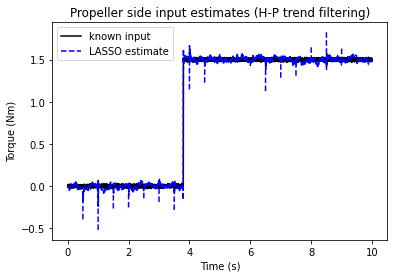

In [86]:
for i in range(loop_len):
    plt.plot(sim_time[i*bs:(i+1)*bs], U_step[i*bs:(i+1)*bs,1], linestyle='solid', color='black')
    plt.plot(sim_time[i*bs:(i+1)*bs], lasso_estimates[i][1::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Propeller side input estimates (H-P trend filtering)')
plt.show()

## 2)

In [ ]:
U = np.zeros((len(sim_time), 2))

e1 = np.random.normal(0, .01, U.shape[0])
e2 = np.random.normal(0, .01, U.shape[0])

U[:,0] += 5 + e1
U[:,1] -= 2 + np.sin(5*2*np.pi*sim_time) + e2

In [ ]:
plt.plot(sim_time, U, label=('motor', 'propeller'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [ ]:
time_meas, measurements, _ = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, dst), U, t=sim_time)

In [ ]:
measurement_error = np.random.normal(0, .02, measurements.shape[0]).reshape(-1,1)
measurements_noise = measurements + measurement_error

In [ ]:
plt.plot(time_meas, measurements_noise[:,:-1], label=('speed1', 'speed2'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rot. speed (rad/s)')
plt.ylim(636,637)
plt.xlim(8,8.5)
plt.show()

In [ ]:
plt.plot(time_meas, measurements_noise[:,-1], label='torque transducer')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [ ]:
x_tikhonov = np.zeros((O_mat.shape[1], 1))
x_lasso = np.zeros((O_mat.shape[1], 1))

tikh_estimates = []
lasso_estimates = []

In [ ]:
for i in range(loop_len):
    batch = measurements_noise[i*bs:(i+1)*bs,:]
    y_noise = batch.reshape(-1,1)
    
    print('Initial state estimate (Tikhonov):\n', x_tikhonov.T)
    print('Initial state estimate (LASSO):\n', x_lasso.T)
    
    tikhonov_estimate, x_tikhonov = tikhonov_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=x_tikhonov, lam=0.05)
    lasso_estimate, x_lasso = lasso_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=x_lasso, lam=0.05)
    
    t_est = tikhonov_estimate[-2:,:]
    l_est = lasso_estimate[-2:,:]
    print(t_est, l_est)
    
    #x_tikhonov = A_mat_d @ x_tikhonov + B_mat_d @ t_est
    #x_lasso = A_mat_d @ x_lasso + B_mat_d @ l_est
    
    x_est_t = omat @ x_tikhonov + gmat @ tikhonov_estimate
    x_tikhonov = x_est_t[-A_mat_d.shape[0]:,:]
    x_est_l = omat @ x_lasso + gmat @ lasso_estimate
    x_lasso = x_est_l[-A_mat_d.shape[0]:,:]
    
    print('New initial state estimate (Tikhonov):\n', x_tikhonov.T)
    print('New initial state estimate (LASSO):\n', x_lasso.T)
    
    tikh_estimates.append(tikhonov_estimate)
    lasso_estimates.append(lasso_estimate)

In [ ]:
for i in range(loop_len):
    plt.plot(sim_time[i*bs:(i+1)*bs], U[i*bs:(i+1)*bs,0], linestyle='solid', color='black')
    plt.plot(sim_time[i*bs:(i+1)*bs], tikh_estimates[i][::2], linestyle='dotted', alpha=0.2, color='red')
    plt.plot(sim_time[i*bs:(i+1)*bs], lasso_estimates[i][::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'Tikhonov estimate', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor side input estimates (H-P trend filtering)')
#plt.ylim(4.95, 5.05)
#plt.xlim(0.4,0.6)
plt.show()

In [ ]:
for i in range(loop_len):
    plt.plot(sim_time[i*bs:(i+1)*bs], U[i*bs:(i+1)*bs,1], linestyle='solid', color='black')
    plt.plot(sim_time[i*bs:(i+1)*bs], tikh_estimates[i][1::2], linestyle='dotted', alpha=0.5, color='red')
    plt.plot(sim_time[i*bs:(i+1)*bs], lasso_estimates[i][1::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'Tikhonov estimate', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Propeller side input estimates (H-P trend filtering)')
#plt.ylim(-4, 0)
#plt.xlim(0.4,0.6)
plt.show()